In [19]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


def euclidean_distance(x, y):
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def conc(vects):
    x, y = vects
    conc1 = concatenate([x,y])
    return conc1

def conc_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],32)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    x = y_pred[:,0:128]
    y = y_pred[:,128:268]
    y_pred1 = euclidean_distance(x,y)
    p = x
    q = y
    p = K.clip(p, K.epsilon(), 1)
    q = K.clip(q, K.epsilon(), 1)
    #y_true1 = y_true[:,0]
    #y_true1 = K.reshape(y_true1,(-1,))
    #print(y_true1)
    #tr_same = y_true[:,1]
    #tr_same = K.reshape(tr_same, (-1,))
    y_true1 = y_true
    tr_same = K.round(y_true/3)
    margin = 1
    test = 0.001*K.sum(p*K.abs(K.log(p)-K.log(q)), axis=1)

    return K.mean((1-tr_same)*(y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))
                 + (tr_same)*test)

def triplet_loss(y_true, y_pred):
    x = y_pred[:,0:32]
    y = y_pred[:,32:64]
    y_pred1 = euclidean_distance(x,y)
    y_true1 = y_true
    margin = 1
    return K.mean(y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))

def coral_loss(y_true, y_pred):
    x = y_pred[:,0:32]
    y = y_pred[:,32:64]
    n = 32.0
    mul1 = K.dot(K.transpose(x),x)
    one = x*0+1
    mul2 = K.dot(K.transpose(one), x)
    sub = K.dot(K.transpose(mul2), mul2)
    source = (mul1 - (sub)/n)/(n-1)
    source = K.abs(source)
    source = K.clip(source, K.epsilon(),10000)
    source1 = K.log(source)
    
    mul11 = K.dot(K.transpose(y),y)
    mul21 = K.dot(K.transpose(one), y)
    sub1 = K.dot(K.transpose(mul2), mul2)
    n = float(n)
    target = (mul11 - (sub1)/n)/(n-1)
    target = K.abs(target)
    target = K.clip(target, K.epsilon(),10000)
    target1 = K.log(target)
    
    return (K.sum(K.dot((source1-target1),(source1-target1)))/(4*32*32.0))
       
    

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(7)]) - 1
    for d in range(7):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1,7)
            dn = (d + inc) % 7
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_addi_pairs(x, y):
    pairs = []
    labels = []
    for i in range(0,1000):
        k1 = random.randrange(0,x.shape[0])
        for j in range(0,10):
            k2 = random.randrange(0, y.shape[0])
            pairs+= [[x[k1],y[k2]]]
            labels += [3]
    return np.array(pairs), np.array(labels)
             
            
def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(64, input_shape=(64,), activation='relu'))
    #seq.add(Dense(64, activation='relu'))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(32, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



In [20]:
import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaCentre.mat')
arr = mat['pavia']
arr = np.array(arr)
print(arr.shape)

import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaCentre_gt.mat')
arr1 = mat['pavia_gt']
arr1 = np.array(arr1)
print(arr1.shape)

a=[]
label=[]
k=0
for i in range(0,arr1.shape[0]):
    for j in range(0,arr1[i].shape[0]):
        a.append(arr[i][j])
        label.append(arr1[i][j])
        
a=np.array(a)
label=np.array(label)

X_train=[]
y_train=[]
for i in range (0,a.shape[0]):
    if(label[i]==2):
        y_train.append(0)
    if(label[i]==3):
        y_train.append(1)
    if(label[i]==4):
        y_train.append(2)
    if(label[i]==5):
        y_train.append(3)
    if(label[i]==7):
        y_train.append(4)
    if(label[i]==8):
        y_train.append(5)
    if(label[i]==9):
        y_train.append(6)
    if (label[i]==2 or label[i]==3 or label[i]==4 or label[i]==5 or label[i]==7 or label[i]==8 or label[i]==9):
        X_train.append(a[i])
X_train=np.array(X_train)
y_train=np.array(y_train)
print(X_train.shape)
print(y_train.shape)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state = 0)

from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
X_train = pca.fit_transform(X_train)
print(X_train.shape)


(1096, 715, 102)
(1096, 715)
(72933, 102)
(72933,)


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(72933, 64)


In [21]:
print(label.max())

9


In [22]:
import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaU.mat')
arr = mat['paviaU']
arr = np.array(arr)

import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaU_gt.mat')
arr1 = mat['paviaU_gt']
arr1 = np.array(arr1)
print(arr1.shape)

a=[]
label=[]
k=0
for i in range(0,arr1.shape[0]):
    for j in range(0,arr1[i].shape[0]):
        a.append(arr[i][j])
        label.append(arr1[i][j])
        
a=np.array(a)
label=np.array(label)
print(a.shape)
print(label.shape)

X_train1=[]
y_train1=[]
for i in range (0,a.shape[0]):
    if(label[i]==4):
        y_train1.append(0)
    if(label[i]==1):
        y_train1.append(1)
    if(label[i]==8):
        y_train1.append(2)
    if(label[i]==7):
        y_train1.append(3)
    if(label[i]==9):
        y_train1.append(4)
    if(label[i]==2):
        y_train1.append(5)
    if(label[i]==6):
        y_train1.append(6)
    if (label[i]==4 or label[i]==1 or label[i]==8 or label[i]==7 or label[i]==9 or label[i]==2 or label[i]==6):
        X_train1.append(a[i])
X_train1=np.array(X_train1)
y_train1=np.array(y_train1)

from sklearn.utils import shuffle
X_train1, y_train1 = shuffle(X_train1, y_train1, random_state = 0)
from sklearn.preprocessing import StandardScaler
X_train1 = StandardScaler().fit_transform(X_train1)
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
X_train1 = pca.fit_transform(X_train1)
print(X_train1.shape)


(610, 340)
(207400, 103)
(207400,)


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(39332, 64)


In [23]:
print(X_train.max())
print(X_train1.max())
X_train=X_train.astype('float32')
X_train1=X_train1.astype('float32')

47.423585702771796
104.56701566525479


In [24]:
print(X_train.min())
print(X_train1.min())

-19.61208
-19.46586


In [25]:
X_train=X_train/100
X_train1=X_train1/100

In [26]:
X_test=X_train[50000:72933,:]
y_test=y_train[50000:72933]
X_train=X_train[0:50000,:]
y_train=y_train[0:50000]

print(X_train1.shape)
print(X_test.shape)

(39332, 64)
(22933, 64)


In [27]:
print((X_train).max())
print(abs(X_train1).max())
print(abs(X_test).max())
print(X_train.min())
print(X_train1.min())

0.47423583
1.0456702
0.36481896
-0.19607832
-0.1946586


In [28]:
digit_indices = [np.where(y_train1 == i)[0] for i in range(7)]
tr_pairs, tr_y = create_pairs(X_train1, digit_indices)

In [29]:
tr1_pairs, tr1_y = create_addi_pairs(X_train1, X_train)

In [30]:
print(tr_pairs.shape)
print(tr1_pairs.shape)

(13244, 2, 64)
(10000, 2, 64)


In [31]:

# network definition
input_dim=X_train.shape[1:]
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(conc, output_shape=conc_shape)([processed_a, processed_b])
print(distance.shape)

model = Model(input=[input_a, input_b], output=distance)

(?, 64)
(?, 64)


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`


In [32]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


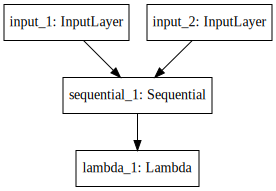

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [34]:
print(tr_pairs[:,0].shape)
print(tr_pairs[:,1].shape)
print(tr_y.shape)

(13244, 64)
(13244, 64)
(13244,)


In [35]:
# train
from keras import optimizers
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rms = RMSprop()
for i in range(0,50):
     model.compile(loss=triplet_loss, optimizer=rms)
     model.fit([tr_pairs[:,0], tr_pairs[:, 1]], tr_y, batch_size=64, nb_epoch=1)
     model.compile(loss=coral_loss, optimizer=rms)
     model.fit([tr1_pairs[:,0], tr1_pairs[:, 1]], tr1_y, batch_size=64, nb_epoch=1)
     

        

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/1
13244/13244 [==============================] - 5s 391us/step - loss: 0.1402


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/1
10000/10000 [==============================] - 1s 65us/step - loss: 0.0313
Epoch 1/1
13244/13244 [==============================] - 1s 56us/step - loss: 0.0863
Epoch 1/1
10000/10000 [==============================] - 1s 64us/step - loss: 1.5098e-06
Epoch 1/1
13244/13244 [==============================] - 1s 60us/step - loss: 0.0851
Epoch 1/1
10000/10000 [==============================] - 1s 68us/step - loss: 2.0988e-07
Epoch 1/1
13244/13244 [==============================] - 1s 62us/step - loss: 0.0795
Epoch 1/1
10000/10000 [==============================] - 1s 70us/step - loss: 1.1944e-07
Epoch 1/1
13244/13244 [==============================] - 1s 64us/step - loss: 0.0758
Epoch 1/1
10000/10000 [==============================] - 1s 78us/step - loss: 6.4435e-08
Epoch 1/1
13244/13244 [==============================] - 1s 73us/step - loss: 0.0732
Epoch 1/1
10000/10000 [==============================] - 1s 79us/step - loss: 3.7007e-08
Epoch 1/1
13244/13244 [======================

13244/13244 [==============================] - 3s 259us/step - loss: 0.0560
Epoch 1/1
10000/10000 [==============================] - 3s 298us/step - loss: 1.2218e-09
Epoch 1/1
13244/13244 [==============================] - 3s 233us/step - loss: 0.0538
Epoch 1/1
10000/10000 [==============================] - 3s 268us/step - loss: 1.5084e-09
Epoch 1/1
13244/13244 [==============================] - 3s 208us/step - loss: 0.0501
Epoch 1/1
10000/10000 [==============================] - 2s 247us/step - loss: 1.0718e-09


In [36]:
processed=test_model.predict(X_train1)
print(processed[200])
print(processed[100].shape)

[ 0.         4.965361  13.302396   6.320362  10.606984  15.5667095
 15.979755   9.913061   9.64227    0.        15.32056    1.6860005
  5.518911   9.726227  12.172305   7.5437403  0.        11.856464
  1.0385636  5.3553824 14.767351   5.968116  11.950812  15.275465
 15.356604  14.776543   8.37546    6.332607   8.070862   9.592548
 15.130781   4.532213 ]
(32,)


In [37]:
from keras.utils import np_utils
y_tr = np_utils.to_categorical(y_train)
y_tr1 = np_utils.to_categorical(y_train1)
y_te = np_utils.to_categorical(y_test)
num_classes = 7
print(y_tr.shape)
print(y_tr1.shape)
print(y_te.shape)

(50000, 7)
(39332, 7)
(22933, 7)


In [38]:
num_pixels = 32
# define baseline model
def baseline_model1():
	# create model
	model = Sequential()
	model.add(Dense(32, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(16, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [39]:
processed_train = test_model.predict(X_train)
processed_train1 = test_model.predict(X_train1)
processed_test = test_model.predict(X_test)
print(processed_train.shape)
print(processed_train1.shape)
print(processed_test.shape)

(50000, 32)
(39332, 32)
(22933, 32)


In [40]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train1, y_tr1, validation_data=(processed_train, y_tr), epochs=100, batch_size=128, verbose=1)
# Final evaluation of the model



Train on 39332 samples, validate on 50000 samples
Epoch 1/100
39332/39332 [==============================] - 4s 104us/step - loss: 1.5566 - acc: 0.4741 - val_loss: 1.6217 - val_acc: 0.5872
Epoch 2/100
39332/39332 [==============================] - 2s 59us/step - loss: 1.5436 - acc: 0.4741 - val_loss: 1.6176 - val_acc: 0.5872
Epoch 3/100
39332/39332 [==============================] - 2s 56us/step - loss: 1.5443 - acc: 0.4741 - val_loss: 1.5919 - val_acc: 0.5872
Epoch 4/100
39332/39332 [==============================] - 2s 48us/step - loss: 1.5441 - acc: 0.4741 - val_loss: 1.6173 - val_acc: 0.5872
Epoch 5/100
39332/39332 [==============================] - 2s 47us/step - loss: 1.5442 - acc: 0.4741 - val_loss: 1.6178 - val_acc: 0.5872
Epoch 6/100
39332/39332 [==============================] - 2s 50us/step - loss: 1.5436 - acc: 0.4741 - val_loss: 1.6277 - val_acc: 0.5872
Epoch 7/100
39332/39332 [==============================] - 2s 46us/step - loss: 1.5438 - acc: 0.4741 - val_loss: 1.6440 -

39332/39332 [==============================] - 2s 47us/step - loss: 1.2970 - acc: 0.4743 - val_loss: 2.1236 - val_acc: 0.5707
Epoch 60/100
39332/39332 [==============================] - 2s 46us/step - loss: 1.2957 - acc: 0.4728 - val_loss: 2.0029 - val_acc: 0.5641
Epoch 61/100
39332/39332 [==============================] - 2s 47us/step - loss: 1.2902 - acc: 0.4770 - val_loss: 1.9803 - val_acc: 0.5470
Epoch 62/100
39332/39332 [==============================] - 2s 47us/step - loss: 1.2836 - acc: 0.4772 - val_loss: 2.0640 - val_acc: 0.5680
Epoch 63/100
39332/39332 [==============================] - 2s 46us/step - loss: 1.2884 - acc: 0.4748 - val_loss: 2.1910 - val_acc: 0.5736
Epoch 64/100
39332/39332 [==============================] - 2s 48us/step - loss: 1.2859 - acc: 0.4741 - val_loss: 2.1412 - val_acc: 0.5728
Epoch 65/100
39332/39332 [==============================] - 2s 46us/step - loss: 1.2937 - acc: 0.4741 - val_loss: 2.0093 - val_acc: 0.5444
Epoch 66/100
39332/39332 [==============

In [41]:
#32 output dim new
#CORAL
# acc 47.72
scores_train = model1.evaluate(processed_train1, y_tr1, verbose=1)
scores_test = model1.evaluate(processed_test, y_te, verbose=1)
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

22933/22933 [==============================] - 1s 45us/step
* Accuracy on training set: 48.55%
* Accuracy on test set: 56.32%
